In [6]:
import pandas as pd

drug_df = pd.read_csv("Data/drug200.csv")
drug_df = drug_df.sample(frac=1)
drug_df.head(3)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
26,31,M,HIGH,HIGH,30.366,DrugY
120,28,M,NORMAL,HIGH,27.064,DrugY
186,70,M,HIGH,HIGH,9.849,drugB


In [8]:
from sklearn.model_selection import train_test_split

X = drug_df.drop("Drug", axis=1).values
y = drug_df["Drug"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=125
)

## Processing Pipeline

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

In [10]:
# categorical column
cat_col = [1,2,3]
# numerical column
num_col = [0,4]

transform = ColumnTransformer(
    [
        ("encoder", OrdinalEncoder(), cat_col),
        ("num_imputer", SimpleImputer(strategy="median"), num_col),
        ("num_scaler", StandardScaler(), num_col),
    ]
)

pipe = Pipeline(
    steps=[
        ("preprocessing", transform),
        ("model", RandomForestClassifier(n_estimators=100, random_state=125 )),
    ]
)

In [11]:
pipe.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('encoder', ...), ('num_imputer', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Evaluation

In [14]:
from sklearn.metrics import accuracy_score, f1_score

predictions = pipe.predict(X_test)
accuracy=accuracy_score(y_test, predictions)
f1=f1_score(y_test, predictions, average="weighted")
print("Accuracy: ", accuracy)
print("F1 Score: ", f1)

print("Accuracy:", str(round(accuracy, 2) * 100) + "%", "F1:", round(f1, 2))

with open("Results/metrics.txt", "w") as outfile:
    outfile.write(f"\nAccuracy = {round(accuracy, 2)}, F1 Score = {round(f1, 2)}.")

Accuracy:  0.9333333333333333
F1 Score:  0.9271344545538095
Accuracy: 93.0% F1: 0.93


## Visualise Results

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

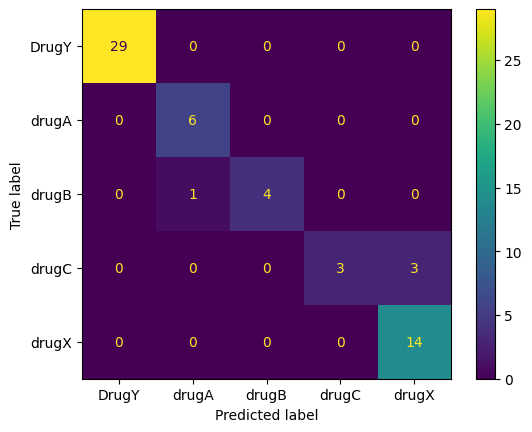

In [17]:
cm = confusion_matrix(y_test, predictions, labels=pipe.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)

disp.plot()
plt.savefig("Results/confusion_matrix.png", dpi=120)

## Save Model

In [18]:
import skops.io as sio

In [23]:
sio.dump(pipe, "Models/drug_pipeline.skops")

In [27]:
import os

untrusted_types = sio.get_untrusted_types(file="Models/drug_pipeline.skops")
if untrusted_types:
    print("Untrusted types found:", untrusted_types)

model = sio.load("Models/drug_pipeline.skops", trusted=untrusted_types) if os.path.exists("Models/drug_pipeline.skops") else None
 
if model:
    model_predictions = model.predict(X_test)
    model_accuracy = accuracy_score(y_test, model_predictions)
    print("Loaded Model Accuracy: ", model_accuracy)

Untrusted types found: ['numpy.dtype']
Loaded Model Accuracy:  0.9333333333333333
